# r/IndieMusicFeedback Data Scrape

r/IndieMusicFeedback is a music feedback subreddit. After commenting on 5 other posts, users upload a link with their song on it and mark a genre.

In the month of December 2020:
  - What genre is posted the most frequently in r/IndieMusicFeedback?
  - What URL do users redirect their posts to?

## Scraping from Reddit

In [129]:
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import praw
from urllib.parse import urlparse
import numpy as np
import pprint
import pandas as pd

We need to use the reddit API with the praw package to access the data. Here's a link how to do that here:
https://alpscode.com/blog/how-to-use-reddit-api/


In [130]:
URL = 'https://www.reddit.com/r/IndieMusicFeedback/'

page = requests.get(URL)

bs = BeautifulSoup(page.content, 'html.parser')

reddit = praw.Reddit(client_id='REDACTED', 
                     client_secret='REDACTED', 
                     user_agent='IndieMusicFeedBack Scraping')

The subreddit that I'm using is called r/IndieMusicFeedback. It's a music feedback forum for musicians and artists where each user is required to comment on 5 posts (with more than 110 characters) before they are allowed to post. 

https://api.pushshift.io/reddit/submission/search/?after=1577836800&before=1609459199&sort_type=score&sort=desc&subreddit=IndieMusicFeedback

Now we need to access the data. I want to see what we can find for all of December 2020 on this subreddit. Reddit uses unix time, so I'm using a basic converter I found online to save me some time: https://www.epochconverter.com/. 
Let's get a quick look at the data.

In [132]:
imf = reddit.subreddit('IndieMusicFeedback').new(limit = 1000)
count = 0
posts = []

for post in imf:
    #between jan 2020 and jan 2021
    if 1577836800 < post.created_utc < 1609459200:
        posts.append([link_flair_text, post.title, post.url,post.created_utc, post.score, post.num_comments, post.upvote_ratio, count])
    count += 1
posts = pd.Dataframe(posts, columns = ['Genre','Post','URL','Upload_Time','Score','Comments','Upvote_Ratio','Count'])    

ResponseException: received 401 HTTP response

## Cleaning the data

I'm cleaning the data as it's going in- making sure all the youtube/reddit/soundcloud/spotify links are alike so I can use them for later. 

Now we are working with the csv, so I'll clean the data by:
- stripping the URL's
- Adjusting the comments (bots add 2 comments to every post, need to adjust)
- Converting from Unix to date-time (so we can stick within december)

In [4]:
IMF_df = pd.read_csv('IMF_DECEMBER.csv')

IMF_df.loc[(IMF_df['URL'] == 'youtu.be') | (IMF_df['URL'] == 'm.youtube') | (IMF_df['URL'] == 'music.youtube'), 'URL'] = 'youtube'
IMF_df.loc[(IMF_df['URL'] == 'i.redd.it') | (IMF_df['URL'] == 'v.redd.it'), 'URL'] = 'reddit'                             
IMF_df.loc[IMF_df['URL'] == 'soundcloud.app.goo.gl', 'URL'] = 'soundcloud'
IMF_df.loc[IMF_df['URL'] == 'm.soundcloud', 'URL'] = 'soundcloud'
IMF_df.loc[IMF_df['URL'] == 'open.spotify', 'URL'] = 'spotify'  
IMF_df.loc[IMF_df['URL'].str.contains('.bandcamp'), 'URL'] = 'bandcamp'


IMF_df['Upload Time'] = pd.to_datetime(IMF_df['Upload Time'], unit = 's')
IMF_df = IMF_df.drop(IMF_df.index[891:932])

IMF_df['Comments'] = IMF_df['Comments'] - 2

IMF_df

,Genre,Title,URL,Upload Time,Post Score,Comments,Upvote Ratio
0,Lofi,Lo-F1 by CaseOfficialMusic | Case Official Mus...,soundcloud,2021-01-01 00:29:14,1,9,1.0
1,Electronic,"Hi IMF, i proudly present my 2nd release ""Cons...",soundcloud,2020-12-31 23:57:07,1,3,1.0
2,Acoustic Rock,Cover: Jane Says - Jane's Addiction | This is ...,soundcloud,2020-12-31 23:56:35,2,0,1.0
3,90s,"New Jack Swing - Across The Pond. Man, the New...",soundcloud,2020-12-31 23:26:36,1,0,1.0
4,Folk Rock,"So, this is different for me, but I have a fol...",bandcamp,2020-12-31 22:30:06,2,2,1.0
...,...,...,...,...,...,...,...
886,RnB,Get You - Daniel Caesar Guitar Loop,youtube,2020-12-01 13:39:39,6,22,1.0
887,Instrumental Hip Hop,I made Freddie Dredd Type Beat. I know there’s...,soundcloud,2020-12-01 12:38:54,3,9,1.0
888,Hip-hop & Rap,maybe your god is like that (ft. Bjorn Vader),youtube,2020-12-01 04:32:58,1,16,1.0
889,Alternative,My first time ever posting here. I’ve given fe...,youtube,2020-12-01 01:12:05,1,6,1.0


In [25]:
IMF_df['Genre'].describe()

count                  878
unique                 125
top       Alternative Rock
freq                    57
Name: Genre, dtype: object

In [68]:
genre_count_df = pd.DataFrame(IMF_df['Genre'].value_counts(ascending = False))
pd.set_option('display.max_rows', genre_count_df.shape[0]+1)
genre_count_df.sum()
top_10= genre_count_df.nlargest(10,'Genre')
top_10.sum()

Genre    379
dtype: int64

Text(0.5, 0, 'Genre')

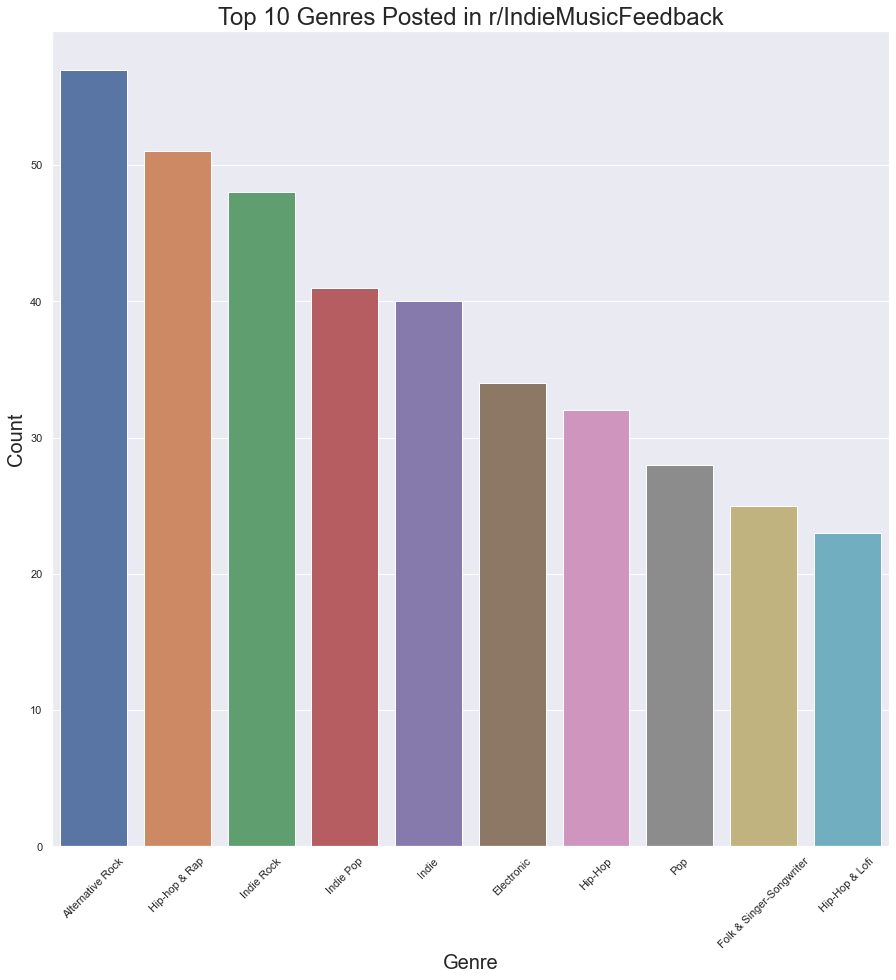

In [119]:
sns.set_theme(style="whitegrid")
sns.color_palette("coolwarm", as_cmap=True)
sns.set(rc={'figure.figsize':(15,15)})
genre_plot =sns.barplot(x = top_10.index , y = 'Genre', data= top_10,
            label="Total"
           )
sns.set(font_scale=2)
plt.xticks(rotation=45)
genre_plot.set_title('Top 10 Genres Posted in r/IndieMusicFeedback')
genre_plot.set_ylabel('Count',fontsize=20)
genre_plot.set_xlabel('Genre',fontsize=20)

Interestingly enough, these top 10 genres make up less than HALF (380/879) of the total 879 submisssions from december.

## Where do user-submitted URL's go to?

Users submit URL's with their music so other users can give feedback.

In [122]:
url_count_df = IMF_df['URL'].value_counts()
url_count_df = url_count_df.to_frame()
url_count_df_new = url_count_df.rename(columns={'URL': 'COUNT'}, index={'': 'URL'})

url_count_df_filtered = url_count_df_new[url_count_df_new['COUNT'] >= 5] 
url_count_df_filtered

,COUNT
youtube,375
soundcloud,261
spotify,140
reddit,75
bandcamp,27


I filtered out URL's that came up less than 5 times – they were the obscure ones that nobody really posted. 

Based on my own experience on the site, I'm pretty surprised how Youtube is the highest- I would have thought soundcloud is the most used redirect link because in my experience on the subreddit, I get a lot of soundcloud links... Or maybe I just choose to go there because it's a personal preference. 

Text(0.5, 0, 'URL')

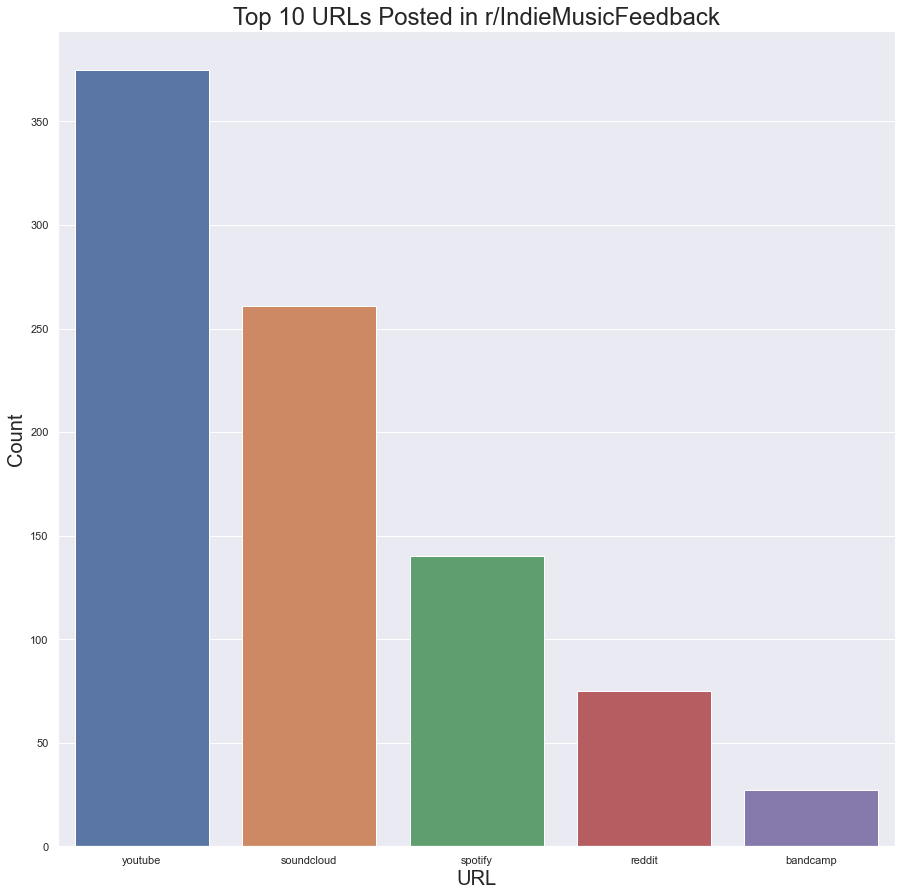

In [138]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(15,15)})
sns.color_palette("coolwarm", as_cmap=True)
barplot = sns.barplot(x = url_count_df_filtered.index , y = 'COUNT', data= url_count_df_filtered,
            label="Total")
sns.set(font_scale=2)
barplot.set_title('Top 10 URL''s Posted in r/IndieMusicFeedback')
barplot.set_ylabel('Count',fontsize=20)
barplot.set_xlabel('URL',fontsize=20)